# Import

In [129]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp

# Define Class

In [743]:
class Region(object):
    '''
    Region class: Define an ad-hoc communication network and run related analysis
    
    Data:
        x_range, y_range: int, the size of rectangular overall communication network
        map: np.ndarray, the map of communication network contains coverage situation
    '''
    def __init__(self, m, n):
        '''
        Create Region with user defined size m * n.
        
        params:
            m,n: int > 0
        '''
        assert isinstance(m,int), "m must be int"
        assert isinstance(n,int), "n must be int"
        assert (m>0) and (n>0), "Please set m>0 and n>0"
        
        self.x_range = m
        self.y_range = n
        self.map = np.zeros((self.x_range,self.y_range))
        
        self.max_tower = m * n
        self.max_coverage = m * n
        self.tower = []
        self.sub_rectangle = []
        
    def show_map(self, size = 5, text = False, font_size = 10):
        '''
        Print Current Region Map
        
        params: (optional)
            size: int > 0 (self-defined figure size for output)
            text: bool (whether print index of tower or not)
            font_size: int > 0 (self-defined font size if needed to be printed)
        '''
        assert isinstance(size,int), "Size parameter must be int"
        assert isinstance(text,bool)
        assert isinstance(font_size,int)
        assert size>0, "Please set size>0"
        assert font_size>0, "Please set font_size>0"
        
        # Set Basic Plot parameters
        plt.figure(figsize = (size,size))
        plt.xlim(xmin = 0, xmax = self.x_range)
        plt.ylim(ymin = 0, ymax = self.y_range)
        if self.get_tower_num() == 0: return # No tower
        
        # Plot with different color for each tower
        ax_list = []
        np.random.seed(233)
        for num in range(1,self.get_tower_num()+1):
            random_color = np.random.random(3)
            for i in range(self.x_range):
                for j in range(self.y_range):
                    if text:
                        plt.text(i+0.5,j+0.5,self.map[i,j],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize = font_size)
                    if self.map[i][j] == num:
                        ax_list.append(plt.subplot())
                        ax_list[-1].add_patch(mp.Rectangle((i, j),1,1,alpha=0.5,color=random_color))
        plt.show()

    def add_tower(self, x, y, size_x, size_y):
        '''
        Add new tower
        x,y is the bottom left point of the rectangular area
        
        params:
            x, y: The position of new tower
            size_x, size_y: define size of rectangular area
        '''
        assert isinstance(x,int) and isinstance(y,int), "x and y must be int"
        assert isinstance(size_x,int) and isinstance(size_y,int), "size_x and size_y must be int"
        assert x>=0 and x<self.x_range+1, "Please set 0<=x<"+str(self.x_range+1)
        assert y>=0 and y<self.y_range+1, "Please set 0<=y<"+str(self.y_range+1)
        assert size_x>0 and x+size_x<=self.x_range, "Please set size_x > 0 and x+size_x <= "+str(self.x_range)
        assert size_y>0 and y+size_y<=self.y_range, "Please set size_y > 0 and y+size_y <= "+str(self.y_range)
        
        # Get target area
        target_area = self.map[x:x+size_x, y:y+size_y]
        
        # Check blank area for new tower
        if np.sum((target_area == 0)) == 0:
            pass # No un-covered area in target area, cannot add new tower's subsection
        else:
            # Trim: find maximal blank area for adding new tower's subsection
            max_loc = self.find_max_rectangle(target_area)
            xmin, xmax, ymin, ymax = max_loc[0]+x, max_loc[1]+x, max_loc[2]+y, max_loc[3]+y

            # Add tower and its subsection
            for i in range(xmin,xmax+1):
                for j in range(ymin,ymax+1):
                    self.map[i][j] = self.get_tower_num() + 1
                    
            # Store information in class
            self.tower.append((xmin,ymin))
            self.sub_rectangle.append((xmax-xmin+1,ymax-ymin+1))
        
    def find_max_rectangle(self, np_map):
        '''
        During adding new tower
        Find max blank rectangular area for trimming

        param: 
            np_map: np.array (target area)
        return:
            maximal blank rectangular area in target area
            xmin, xmax, ymin, ymax: corresponded location
        '''
        assert isinstance(np_map,np.ndarray)
        assert len(np_map)>0, "Your target area includes nothing"

        maxArea = -1
        # Search line by line to crreate histogram
        for i in range(len(np_map)):
            row_hist = []
            
            # Count histogram and save into row_list
            for j in range(len(np_map[i])):
                if i==0: 
                    if np_map[i][j] == 0:
                        row_hist.append(1) 
                    else:
                        row_hist.append(0)
                else:
                    if np_map[i][j]!=0:
                        row_hist.append(0)
                    else:
                        # Count height for each column in one row
                        tmp = 0
                        for k in range(i,-1,-1):
                            if np_map[k][j] != 0: 
                                break
                            else:
                                tmp += 1
                        row_hist.append(tmp)

            # Get largest rectangular area in this line's histogram
            area, start_idx, height, width = self.largest_hist_area(row_hist)
            if area > maxArea:
                maxArea = area
                xmax_ref = i
                ymax_ref = start_idx
                xmin_ref = xmax_ref - height
                ymin_ref = ymax_ref - width

        # The returned value is the relative position in target area
        # Not the absolute position in map
        return xmin_ref, xmax_ref, ymin_ref, ymax_ref
    
    def largest_hist_area(self, height):
        '''
        Find the largest rectangular area in a histogram
        Used for each line in the region map
        
        param:
            height: list (each element means the height at that position)
        '''
        assert isinstance(height,list), "parameter height must be a list"
        assert len(height)>0, "height list is empty"
        
        height.append(0)
        stack = [-1]
        maxArea = 0
        save_idx = -1
        save_h = -1
        save_w = -1
        for i in range(len(height)):
            while height[i] < height[stack[-1]]:
                h = height[stack.pop()]
                w = i - stack[-1] - 1
                if h * w > maxArea:
                    maxArea = h * w
                    save_idx = i
                    save_h = h
                    save_w = w
            stack.append(i)
        height.pop()
        if maxArea == 0: return 0,0,0,0
        return maxArea, save_idx-1, save_h-1, save_w-1
        
    def get_tower_num(self):
        '''
        Get current number of tower in region
        '''
        return len(self.tower)
    
    def get_cover_area(self):
        '''
        Get current covered area
        '''
        return np.sum(self.map!=0)
        
    def auto_fill(self, max_try, n_tower, final_cover):
        '''
        Auto fill process with given number of towers and desired coverage
        
        params:
            max_try: int > 0, max number of random generating during one experiment
            n_tower: int > 0, number of towers given
            final_cover: int > 0 and <= self.max_coverage
        return:
            try_count: int, number of generating towers in one auto_fill process
        '''
        assert isinstance(max_try,int)
        assert isinstance(n_tower,int)
        assert isinstance(final_cover,int)
        assert max_try>0, "Please set max_try>0"
        assert n_tower>0, "Please set n_tower>0"
        assert final_cover>0 and final_cover<=self.max_coverage, "Please set 0<final_cover<="+str(self.max_coverage)
        
        # Start adding tower
        try_count = 0
        while try_count < max_try:
            # Check finish condition
            if self.get_tower_num() == self.max_tower: 
                #print("Fullfilled !")
                break # Already Fullfilled
            if self.get_tower_num() == n_tower: 
                #print("Reach limitation for number of towers !")
                break # Reach number of tower limitation
            if final_cover <= self.get_cover_area(): 
                #print("Meet requirement for desired coverage !")
                break # Reach desired coverage
                
            # Generate tower position and coverage randomly
            # Based on uniform distribution
            x_tmp = random.randint(0,self.x_range-1)
            y_tmp = random.randint(0,self.y_range-1)
            x_len_tmp = random.randint(1,self.x_range-x_tmp)
            y_len_tmp = random.randint(1,self.y_range-y_tmp)
            self.add_tower(x_tmp, y_tmp, x_len_tmp, y_len_tmp)
            try_count += 1
            
        return try_count
            
    def reset_map(self):
        '''
        Reset map to initial state
        Primarily used in batch expriment
        '''
        self.map = np.zeros((self.x_range,self.y_range))
        self.tower = []
        self.sub_rectangle = []
            
    def batch_experiment(self, n_exp, try_limit, tower_limit, desired_cover):
        '''
        Run n_exp times auto_fill experiment
        
        params:
            n_exp: int > 0 (number of experiment)
            try_limit: int > 0 (limitation for times of tower generation in each experiment)
            tower_limit: int > 0 (limitation for number of towers in the map of each experiment)
            desired_cover: int > 0 and <= self.max_coverage (user-defined desired coverage)
        return:
            num_try_record: list (contains times of generating towers in the map of each experiment)
            num_tower_record: list (contains final number of towers in the map of each experiment)
            coverage_record: list (contains final coverage in map of each experiment)
        '''
        assert isinstance(n_exp,int), "n_exp must be int"
        assert n_exp>0, "Please set n_exp>0"
        
        num_try_record = []
        num_tower_record = []
        coverage_record = []
        self.reset_map()
        
        for count in range(n_exp):
            n_try = self.auto_fill(try_limit, tower_limit, desired_cover)
            num_try_record.append(n_try)
            num_tower_record.append(self.get_tower_num())
            coverage_record.append(self.get_cover_area())
            self.reset_map()
            
        return num_try_record, num_tower_record, coverage_record
        
        

In [744]:
region = Region(9,9)
exp_result = region.batch_experiment(1000,99999,81,81)

In [747]:
sum(exp_result[0])/len(exp_result[0])

123.676

In [738]:
map1 = Region(9,9)
map1.auto_fill(9999999999,81,81)


85

In [723]:
map1.get_tower_num()

16

In [724]:
map1.get_cover_area()

81

E:\Softwares\Anaconda3\envs\py3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


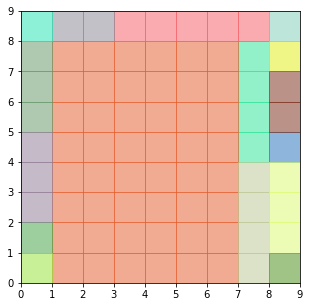

In [726]:
map1.show_map()